In [3]:
import os

os.environ["HTTP_PROXY"] = "http://127.0.0.1:10808"
os.environ["HTTPS_PROXY"] = "http://127.0.0.1:10808"

In [3]:
import json
import pandas as pd

import torch
from torch.optim import AdamW
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from peft import PeftModel
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

2025-03-06 04:38:49.900171: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741207129.921837  514011 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741207129.928520  514011 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-06 04:38:49.951489: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Plink failed to import tkinter.


## Load Data

In [8]:
# Define the directory
tsv_dir = '../Article-Bias-Prediction/data/splits/media'
json_dir = '../Article-Bias-Prediction/data/jsons'

tsv_files = [f for f in os.listdir(tsv_dir) if f.endswith('.tsv')]

data_list = []

for tsv in tsv_files:
    tsv_path = os.path.join(tsv_dir, tsv)
    try:
        df = pd.read_csv(tsv_path, sep='\t')
        print(f"Successfully read {tsv}")
    except Exception as e:
        print(f"Error reading {tsv}: {e}")
    
    for row in df.itertuples():
        file_path = os.path.join(json_dir, f"{row.ID}.json")
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                data["split"] = tsv.split('.')[0]
                data_list.append(data)  # Append JSON data to the list
        except json.JSONDecodeError:
            print(f"Error: {file} contains invalid JSON!")
        except Exception as e:
            print(f"Error reading {file}: {e}")
        

df = pd.DataFrame(data_list)
df.to_csv('data_media_split.csv', index=False)

Successfully read test.tsv
Successfully read train.tsv


Successfully read valid.tsv


In [3]:
df = pd.read_csv("data_random_split.csv")

In [ ]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, HashingTF, MinHashLSH

# Initialize Spark session
spark = SparkSession.builder.appName("Similar Articles") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.executor.memory", "40g") \
        .config("spark.executor.cores", "8") \
        .config("spark.num.executors", "4") \
        .config("spark.executor.memoryOverhead", "4g") \
        .config("spark.driver.memory", "16g") \
        .config("spark.default.parallelism", "96") \
        .config("spark.sql.shuffle.partitions", "96") \
        .getOrCreate()

25/03/06 04:47:51 WARN Utils: Your hostname, Jumbleline resolves to a loopback address: 127.0.1.1; using 192.168.1.123 instead (on interface eno1)
25/03/06 04:47:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
from pyspark.ml.feature import HashingTF, Tokenizer, MinHashLSH
    
# Sample DataFrame (Replace with your data)
df = pd.read_csv("data_random_split.csv")
df = df[["ID", "content"]]
df.rename(columns={"ID": "id"}, inplace=True)
df.dropna(subset=["content"], inplace=True)
df = spark.createDataFrame(df)

df = df.sample(fraction=0.1).cache()

# Step 1: Tokenize the content
tokenizer = Tokenizer(inputCol="content", outputCol="tokens")
tokenized_df = tokenizer.transform(df)

# Step 2: Convert tokens to feature vectors
hashing_tf = HashingTF(
    inputCol="tokens", 
    outputCol="features", 
    binary=True,  # Use binary frequencies for MinHash
)
featurized_df = hashing_tf.transform(tokenized_df)

# Step 3: Initialize and fit MinHash LSH model
mh_lsh = MinHashLSH(
    inputCol="features",
    outputCol="hashes",
    numHashTables=5  # More tables increase accuracy but require more computation
)
model = mh_lsh.fit(featurized_df)

# Step 4: Identify similar articles
similarity_threshold = 0.3  # Jaccard similarity threshold
similar_articles = model.approxSimilarityJoin(
    featurized_df, 
    featurized_df, 
    threshold=similarity_threshold,
    distCol="jaccardDistance"
)

# Filter out self-comparisons and show results
similar_articles = similar_articles.filter("datasetA.id < datasetB.id")

# Display similar pairs with similarity score
similar_articles.select(
    "datasetA.id", 
    "datasetB.id", 
    (1 - similar_articles["jaccardDistance"]).alias("similarity")
).show()

25/03/06 04:49:27 INFO CodeGenerator: Code generated in 3.738418 ms
25/03/06 04:49:27 INFO DAGScheduler: Got job 6 (showString at <unknown>:0) with 96 output partitions
25/03/06 04:49:27 INFO DAGScheduler: Final stage: ResultStage 11 (showString at <unknown>:0)
25/03/06 04:49:27 INFO DAGScheduler: Parents of final stage: List()
25/03/06 04:49:27 INFO DAGScheduler: Missing parents: List()
25/03/06 04:49:27 INFO DAGScheduler: Submitting ResultStage 11 (*(1) Sample 0.0, 0.1, false, 481434981628956761
+- *(1) Scan ExistingRDD[id#230,content#231]
 MapPartitionsRDD[35] at showString at <unknown>:0), which has no missing parents
25/03/06 04:49:27 INFO MemoryStore: Block broadcast_6 stored as values in memory (estimated size 15.6 KiB, free 9.4 GiB)
25/03/06 04:49:27 INFO MemoryStore: Block broadcast_6_piece0 stored as bytes in memory (estimated size 7.9 KiB, free 9.4 GiB)
25/03/06 04:49:27 INFO BlockManagerInfo: Added broadcast_6_piece0 in memory on 192.168.1.123:38229 (size: 7.9 KiB, free: 9.

+---+---+----------+
| id| id|similarity|
+---+---+----------+
+---+---+----------+



25/03/06 04:49:59 INFO Executor: Finished task 62.0 in stage 17.0 (TID 910). 7532 bytes result sent to driver
25/03/06 04:49:59 INFO TaskSetManager: Finished task 62.0 in stage 17.0 (TID 910) in 27179 ms on 192.168.1.123 (executor driver) (77/77)
25/03/06 04:49:59 INFO TaskSchedulerImpl: Removed TaskSet 17.0, whose tasks have all completed, from pool 
25/03/06 04:49:59 INFO DAGScheduler: ShuffleMapStage 17 (showString at <unknown>:0) finished in 27.199 s
25/03/06 04:49:59 INFO DAGScheduler: looking for newly runnable stages
25/03/06 04:49:59 INFO DAGScheduler: running: Set()
25/03/06 04:49:59 INFO DAGScheduler: waiting: Set()
25/03/06 04:49:59 INFO DAGScheduler: failed: Set()


<Axes: title={'center': 'Content Length'}, ylabel='Frequency'>

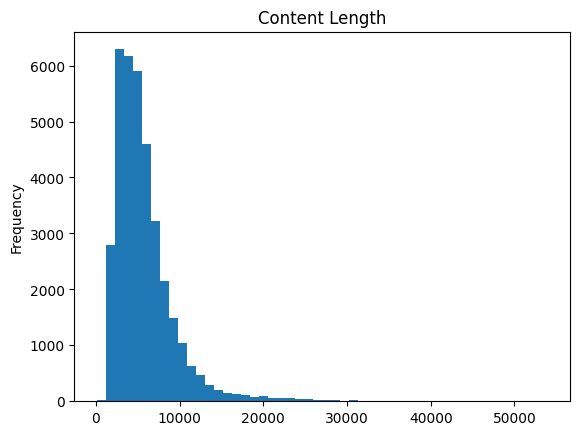

In [4]:
# Plot content length
df['content_length'] = df['content'].apply(len)
df['content_length'].plot.hist(bins=50, title="Content Length")

<Axes: title={'center': 'Size of split=train,val,test'}, xlabel='split'>

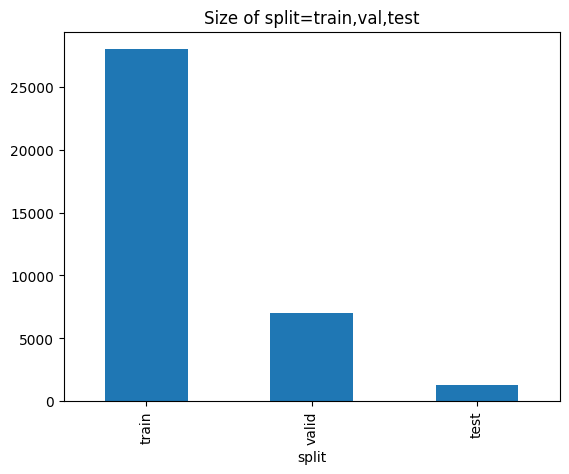

In [5]:
# Plot size of split=train,val,test

df['split'].value_counts().plot(kind='bar', title="Size of split=train,val,test")

## Existing Llama Model

In [12]:
# 1. Load the *base* LLaMA model for sequence classification
base_model_name = "meta-llama/Llama-3.2-1B"
tokenizer_name = "tokenizer"
access_token = os.environ.get("HF_TOKEN")

model = AutoModelForSequenceClassification.from_pretrained(
    base_model_name,
    token=access_token,
    num_labels=3,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

# Set pad token
tokenizer.add_special_tokens({"pad_token":"[PAD]"})
model.config.pad_token_id = tokenizer.pad_token_id
model.resize_token_embeddings(len(tokenizer))

# 2. Load the LoRA adapter on top of the base model
adapter_path = "best_model"
model = PeftModel.from_pretrained(model, adapter_path)

# 3. Create the pipeline with the specified model and tokenizer
pipeline = transformers.pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer
)


Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
Device set to use cuda:0
The model 'PeftModelForSequenceClassification' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSeq

In [14]:
# Evaluate the model
from sklearn.metrics import accuracy_score

test_data = df[df["split"] == "valid"][:1000]
result = pipeline(test_data["content"].tolist())

accuracy_score(test_data["bias"], [int(r["label"][-1]) for r in result])

0.922

In [12]:
text = """
NEW YORK, March 4 (Reuters) - U.S. President Donald Trump's administration and Ukraine plan to sign the much-debated minerals deal following a disastrous Oval Office meeting Friday in which Ukrainian President Volodymyr Zelenskiy was dismissed from the building, four people familiar with the situation said on Tuesday.
President Donald Trump has told his advisers that he wants to announce the agreement in his address to Congress Tuesday evening, three of the sources said, cautioning that the deal had yet to be signed and the situation could change.
The White House did not immediately respond to a request for comment.
Ukraine’s presidential administration in Kyiv and the Ukrainian embassy in Washington did not immediately respond to requests for comment.
The deal was put on hold on Friday after a contentious Oval Office meeting between Trump and Ukrainian President Volodymyr Zelenskiy that resulted in the Ukrainian leader's swift departure from the White House. Zelenskiy had traveled to Washington to sign the deal.
In that meeting, Trump and Vice President JD Vance berated Zelenskiy, telling him he should thank the U.S. for its support rather than asking for additional aid in front of the U.S. media.
"You're gambling with World War III," Trump said.
U.S. officials have in recent days spoken to officials in Kyiv about signing the minerals deal despite Friday's blow-up, and urged Zelenskiy's advisers to convince the Ukrainian president to apologize openly to Trump, according to one of the people familiar with the matter.
On Tuesday, Zelenskiy posted on X that Ukraine was ready to sign the deal and calling the Oval Office meeting "regrettable."
“Our meeting in Washington, at the White House on Friday, did not go the way it was supposed to be,” Zelenskiy said in his post. "Ukraine is ready to come to the negotiating table as soon as possible to bring lasting peace closer."
It was unclear if the deal has changed. The deal that was to be signed last week included no explicit security guarantees for Ukraine but gave the U.S. access to revenues from Ukraine's natural resources. It also envisaged the Ukrainian government contributing 50% of future monetization of any state-owned natural resources to a U.S.-Ukraine managed reconstruction investment fund.
On Monday, Trump signaled that his administration remained open to signing the deal, telling reporters in a gaggle that Ukraine "should be more appreciative."
"This country has stuck with them through thick and thin," Trump said. "We've given them much more than Europe, and Europe should have given more than us."""

In [24]:
pipeline(text)

[{'label': 'LABEL_2', 'score': 0.9993119239807129}]

## Finetune Llama Model

In [3]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

In [4]:
df = pd.read_csv("data_random_split.csv")

In [5]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
) # setup bits and bytes config

# Load tokenizer
model_name = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, quantization_config=bnb_config, num_labels=3)

# Set pad token
tokenizer.add_special_tokens({"pad_token":"[PAD]"})
model.config.pad_token_id = tokenizer.pad_token_id
model.resize_token_embeddings(len(tokenizer))

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model) # prepares the whole model for kbit training

config = LoraConfig(
    r=8, 
    lora_alpha=32, 
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_CLS"
)

model = get_peft_model(model, config) # Now you get a model ready for QLoRA training

This can be used to load a bitsandbytes version that is different from the PyTorch CUDA version.
If this was unintended set the BNB_CUDA_VERSION variable to an empty string: export BNB_CUDA_VERSION=
If you use the manual override make sure the right libcudart.so is in your LD_LIBRARY_PATH
For example by adding the following to your .bashrc: export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:<path_to_cuda_dir/lib64

`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_re

In [6]:
# Label mapping
label_map = {"left": 0, "center": 1, "right": 2}

# Custom Dataset
class TextClassificationDataset(Dataset):
    def __init__(self, data, label_map, tokenizer):
        self.data = data
        self.label_map = label_map
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]["content"]
        label = self.data.iloc[idx]["bias"]  # Map label correctly
        return {"text": text, "label": label}

# Dynamic Padding in DataLoader
def collate_fn(batch):
    texts = [item["text"] for item in batch]
    labels = torch.tensor([item["label"] for item in batch], dtype=torch.long)

    # Apply dynamic padding
    tokenized = tokenizer(
        texts,
        padding=True,  # Enable dynamic padding
        truncation=True,
        return_tensors="pt"
    )

    return {
        "input_ids": tokenized["input_ids"],
        "attention_mask": tokenized["attention_mask"],
        "labels": labels
    }
    
train_dataset = TextClassificationDataset(df[df["split"] == "train"], label_map, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=4, collate_fn=collate_fn)

val_dataset = TextClassificationDataset(df[df["split"] == "valid"], label_map, tokenizer)
val_dataloader = DataLoader(val_dataset, batch_size=4, collate_fn=collate_fn)

# Test the DataLoader
batch = next(iter(train_dataloader))
print(batch)


{'input_ids': tensor([[128000,  13622,  35748,  ..., 128256, 128256, 128256],
        [128000,    791,  56527,  ..., 128256, 128256, 128256],
        [128000,  12487,   7424,  ...,    279,  26969,    662],
        [128000,  48414,   5513,  ..., 128256, 128256, 128256]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([0, 2, 2, 1])}


In [7]:
from accelerate import Accelerator

# Initialize accelerator
accelerator = Accelerator()
device = accelerator.device

# Wrap model & optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)
model, optimizer, train_dataloader = accelerator.prepare(model, optimizer, train_dataloader)

num_epochs = 3
log_steps = 10  # Log loss every `n` steps

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        optimizer.zero_grad()

        # Move batch to the correct device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass
        accelerator.backward(loss)
        optimizer.step()

        total_loss += loss.item()

        if (step + 1) % log_steps == 0:
            print(f"Epoch {epoch + 1}, Step {step + 1}/{len(train_dataloader)}, Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")

print("Training complete!")


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/home/dotin13/.pyenv/versions/3.11.4/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch 1, Step 10/6995, Loss: 1.3551


KeyboardInterrupt: 

In [ ]:
text = ["Government policies should be more inclusive."]
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

# Get predictions
outputs = model(**inputs)
outputs

## Roberta

In [13]:
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

repository="premsa/political-bias-prediction-allsides-BERT"
model = AutoModelForSequenceClassification.from_pretrained(repository)
tokenizer = AutoTokenizer.from_pretrained(repository)
nlp = pipeline("text-classification", model=model, tokenizer=tokenizer)

print(nlp(text))


Device set to use cuda:0
Token indices sequence length is longer than the specified maximum sequence length for this model (550 > 512). Running this sequence through the model will result in indexing errors


RuntimeError: The size of tensor a (550) must match the size of tensor b (512) at non-singleton dimension 1